XS plotting
===========

This notebook uses the ``pyne.ace`` module to plot cross-sections.
ACE (A Compact ENDF) files are a point-wise representation of cross-section,
considered to be "continuous energy" (as in not discrete) for all practical
purposes.

ACE files originate from processing ENDFs (Evaluated Nuclear Data File) with
some cross section preparation code, such as NJOY.
ACE files already contain some form of approximation compared to ENDFs
(at least some form of doppler broadening, since ACE libraries are for a certain
temperature, and most likely assumptions regarding resolved and unresolved
resonances and how to represent them as points, but I would have to check more
precisely to make a strong statement), so in the future I would like to change
this to using ENDF for the plotting and making these assumptions explicit here.

In [1]:
%matplotlib inline

latex = False

if latex:
    import matplotlib as mpl
    mpl.use("pgf")
    pgf_with_rc_fonts = {
        "font.family": "serif",
        "font.serif": [],                   # use latex default serif font
        "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
    }
    mpl.rcParams.update(pgf_with_rc_fonts)

import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pyne
from pyne import ace

mpl.style.use('seaborn')

plot_config = {'lines.linewidth': 0.5}
mpl.rcParams.update(plot_config)

#if not os.path.isfile("54135JEF311.ace"):
#    from urllib import urlretrieve
#    urlretrieve("https://www-nds.iaea.org/wolfram/w180/beta3/W180.ace", "W180.ace")

ene = 'Neutron energy (MeV)'

xs = '$ \sigma $ (barn)'
xs_t = '$ \sigma_{\mathrm{t}} $ (barn)'
xs_e = '$ \sigma_{\mathrm{e}} $ (barn)'
xs_a = '$ \sigma_{\mathrm{a}} $ (barn)'
xs_f = '$ \sigma_{\mathrm{f}} $ (barn)'
xs_i = '$ \sigma_{\mathrm{i}} $ (barn)'
xs_n2n = '$ \sigma_{\mathrm{n2n}} $ (barn)'
xs_n3n = '$ \sigma_{\mathrm{n3n}} $ (barn)'
xs_gamma = '$ \sigma_{\gamma} $ (barn)'
xs_alpha = '$ \sigma_{\\alpha} $ (barn)'

nut = '$ \\nu_{\mathrm{t}}$'
eta = '$ \eta $ '

/Users/rodrigo/opt/anaconda3/envs/nuclear37/lib/python3.7/site-packages/ipykernel_launcher.py:20: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
/Users/rodrigo/opt/anaconda3/envs/nuclear37/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.rxname is not yet QA compliant.
  return f(*args, **kwds)
/Users/rodrigo/opt/anaconda3/envs/nuclear37/lib/python3.7/importlib/_bootstrap.py:219: QAWarning: pyne.ace is not yet QA compliant.
  return f(*args, **kwds)


The main class in ``pyne.ace`` is called ``Library``. It is instantiated using
the name of an ACE file, in this case one distributed with Serpent.

In [2]:
U235 = ace.Library("/Users/rodrigo/opt/Serpent2/xsdata/jeff311/acedata/92235JEF311.ace")

One can choose to read all tables in the file or selectively read a subset by
specifying an argument to the ``read`` method.

In [3]:
U235.read()

After the call to ``read()``, the Library instance will have a dictionary
called ``tables``.

In [4]:
U235.tables

{'92235.12c': <ACE Continuous-E Neutron Table: 92235.12c>,
 '92235.15c': <ACE Continuous-E Neutron Table: 92235.15c>,
 '92235.18c': <ACE Continuous-E Neutron Table: 92235.18c>,
 '92235.03c': <ACE Continuous-E Neutron Table: 92235.03c>,
 '92235.06c': <ACE Continuous-E Neutron Table: 92235.06c>,
 '92235.09c': <ACE Continuous-E Neutron Table: 92235.09c>}

Each entry in the table corresponds to a temperature.
For example, 06c is 600 K and 12c is 1200 K.

We'll use Uranium at 1200 K, which is a reasonable temperature somewhere inside
the fuel pellet in a typical power reactor.

In [5]:
U235_12 = U235.tables['92235.12c']

Once a table is selected, we can inspect the energy grid.

In [6]:
U235_12.energy

array([1.000e-11, 1.125e-11, 1.250e-11, ..., 1.900e+01, 1.950e+01,
       2.000e+01])

We can also inspect the total cross section.

In [7]:
U235_12.sigma_t

array([3.74017410e+04, 3.52626001e+04, 3.34529512e+04, ...,
       6.23121893e+00, 6.23862304e+00, 6.24461331e+00])

With the energy grid, and the total cross section stored in the tables, we
already have basic plotting capability, as we can see below.
However, notice below that plotting cross sections rarely works well when one
of the axis is linear.

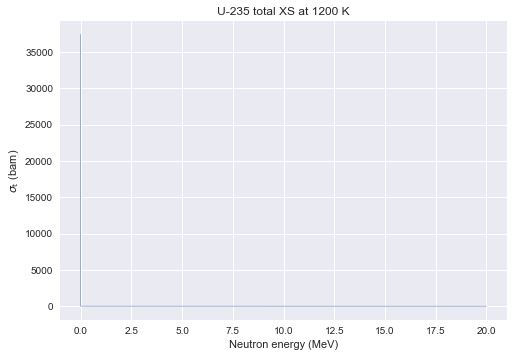

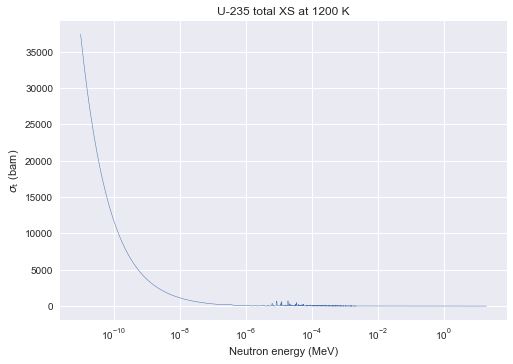

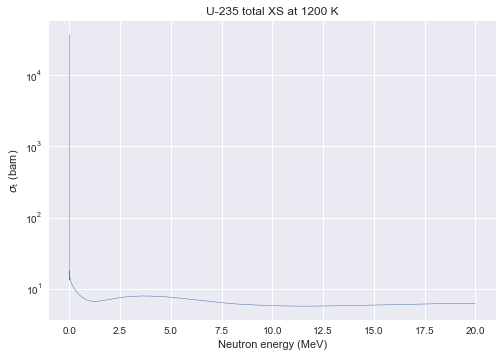

In [8]:
U235_12_ene = U235_12.energy
U235_12_xs_t = U235_12.sigma_t

fig, ax = plt.subplots()
ax.plot(U235_12_ene, U235_12_xs_t)
ax.set(xlabel=ene, ylabel=xs_t, title='U-235 total XS at 1200 K')
plt.savefig('U235_1200K_lin.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.semilogx(U235_12_ene, U235_12_xs_t)
ax.set(xlabel=ene, ylabel=xs_t, title='U-235 total XS at 1200 K')
plt.savefig('U235_1200K_logx.pdf', bbox_inches='tight')

fig, ax = plt.subplots()
ax.semilogy(U235_12_ene, U235_12_xs_t)
ax.set(xlabel=ene, ylabel=xs_t, title='U-235 total XS at 1200 K')
plt.savefig('U235_1200K_logy.pdf', bbox_inches='tight')

Typically, to inspect the whole cross section range and its details you need to
plot using a logarithmic scale on both axis, as shown below.
The caveat is that most people are not very good at thinking on the
logarithmically, which is the same as thinking exponentially (inverse
exponential to be more precise).
Proof of this is how badly people understand how a pandemic spreads.
We witnessed this during the COVID-19.

The good part is that neutrons also lose energy logarithmically, so this eases
the burden or understanding a bit if you ignore their behaviour separately and
only try to understand them together, as an interaction.
The bad part is that if you want to understand both of them separately in
detail, then you can't avoid it, and need to get the skill to think in a
different scale.
The good part for those that put extra effort is that if you learn how to think
in a different scale, you gain extra benefits such as better understanding of
pandemics and other phenomena.

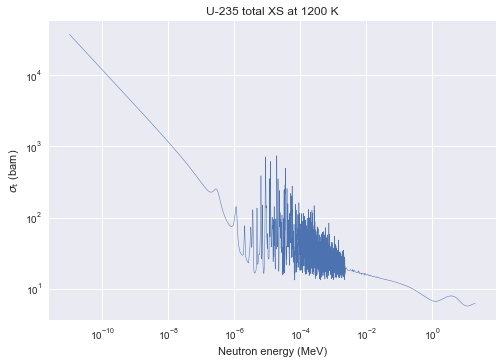

In [9]:
fig, ax = plt.subplots()
ax.loglog(U235_12_ene, U235_12_xs_t)
ax.set(xlabel=ene, ylabel=xs_t, title='U-235 total XS at 1200 K')
plt.savefig('U235_1200K_MT1.pdf', bbox_inches='tight')

Here, I was going to show that the absorption cross section is also available
in the tables, but it seems like there is a bug in the absorption
cross section, since it is showing the same as the radiative capture
cross section (MT 102).

I will use some functionality I haven't shown yet, just to document this bug
for future reference.
Also, when the bug is eliminated, I will be aware of it.

We'll talk about absorption cross section later then, since we can dodge the
bug and calculate it ourselves.

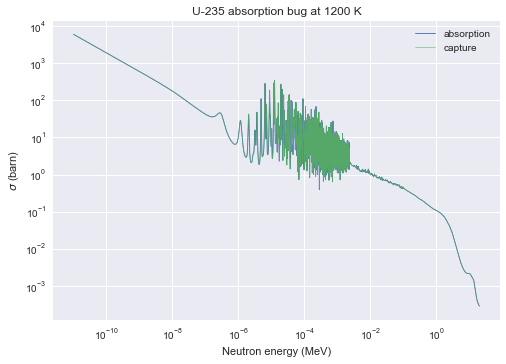

In [10]:
U235_12_xs_a = U235_12.sigma_a
U235_12_xs_c = U235_12.reactions[102].sigma

fig, ax = plt.subplots()
ax.loglog(U235_12_ene, U235_12_xs_a, label='absorption', linewidth=0.9)
ax.loglog(U235_12_ene, U235_12_xs_c, label='capture')
ax.legend()
ax.set(xlabel=ene, ylabel=xs, title='U-235 absorption bug at 1200 K')
plt.savefig('U235_1200K_absorption_bug.pdf', bbox_inches='tight')

In [11]:
bug = np.array_equal(U235_12_xs_a, U235_12_xs_c)

if bug:
    print('The bug is present, so avoid sigma_a')
else:
    print('The bug is gone. The script need to be updated')

print('This is PyNE version', pyne.__version__)

The bug is present, so avoid sigma_a
This is PyNE version 0.5.11


The quantity $ \nu $, which is the amount of neutrons released in a fission
event is also available in the table.

Notice that $ \nu $ has its own energy grid, which is different (smaller) than
the cross section energy grid.
This is because $ \nu $ varies relatively little, so there is no need to have
such a detailed energy grid compared to cross sections showing resonances.

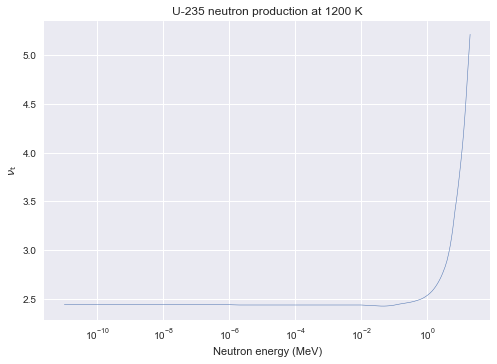

In [12]:
fig, ax = plt.subplots()
ax.semilogx(U235_12.nu_t_energy, U235_12.nu_t_value)
ax.set(xlabel=ene,ylabel=nut, title='U-235 neutron production at 1200 K')
plt.savefig('U235_1200K_nu.pdf', bbox_inches='tight')

To get data on a specific reaction, such as fission or $(n,2n)$, there is an
attribute called ``reactions``.

In [13]:
U235_12.reactions

OrderedDict([(2, <ACE Reaction: MT=2 (z,elastic)>),
             (16, <ACE Reaction: MT=16 >),
             (17, <ACE Reaction: MT=17 >),
             (18, <ACE Reaction: MT=18 >),
             (37, <ACE Reaction: MT=37 >),
             (51, <ACE Reaction: MT=51 >),
             (52, <ACE Reaction: MT=52 >),
             (53, <ACE Reaction: MT=53 >),
             (54, <ACE Reaction: MT=54 >),
             (55, <ACE Reaction: MT=55 >),
             (56, <ACE Reaction: MT=56 >),
             (57, <ACE Reaction: MT=57 >),
             (58, <ACE Reaction: MT=58 >),
             (59, <ACE Reaction: MT=59 >),
             (60, <ACE Reaction: MT=60 >),
             (61, <ACE Reaction: MT=61 >),
             (62, <ACE Reaction: MT=62 >),
             (63, <ACE Reaction: MT=63 >),
             (64, <ACE Reaction: MT=64 >),
             (65, <ACE Reaction: MT=65 >),
             (66, <ACE Reaction: MT=66 >),
             (67, <ACE Reaction: MT=67 >),
             (68, <ACE Reaction: MT=68 >),
  

Some important MT number for reactions are:

| MT  | reaction   | details |
| --- | ---------- | ----------- |
| 1   | n, total   | neutron total cross section <br /> sum of all MTs for incident neutron |
| 2   | n0, n0'    | elastic scattering <br /> conserves kinetic energy <br /> same neutron <br /> *surface interaction? |
| 4   | n, n'      | inelastic scattering <br /> conserves momentum (not kinetic energy) <br /> not same neutron? <br /> sum of MT 50-91 <br /> *bulk interaction with compound nucleus formation? |
| 16  | n, 2n      | production of 2 neutrons plus residual energy |
| 17  | n, 3n      | production of 3 neutrons plus residual energy |
| 18  | n, fission | total fission cross section <br /> sum of MT 19-21,38 (i.e., first, second, third and fourth chance fission)
| 50  | n, n'0     | inelastic scattering with neutron production, leaving the nucleus in the ground state <br /> only meaningful when the incident particle is not a neutron <br /> for an incident neutron, this is represented by elastic scattering MT 2
| 51  | n, n'1     | inelastic scattering with neutron production, leaving the nucleus in the 1<sup>st</sup> excited state <br />
| 52  | n, n'2     | inelastic scattering with neutron production, leaving the nucleus in the 2<sup>nd</sup> excited state <br />
| 90  | n, n'40    | inelastic scattering with neutron production, leaving the nucleus in the 40<sup>th</sup> excited state <br />
| 91  | n, n'c     | inelastic scattering with neutron production in the continuum of energy, not in the discrete representation of MT 50-90
| 101 | n, disap   | disappearance cross section <br /> sum of MT 102-117 |
| 102 | n, gamma   | capture of a neutron with gamma-ray emission <br /> AKA radiative capture |

A more fine-grained description of channels is available at
https://t2.lanl.gov/nis/endf/mts.html

Leaving this aside for now, let's check the fission of U-235 at 1200 K.

In [14]:
U235_12.reactions[18]

<ACE Reaction: MT=18 >

An instance of a reaction contains the reaction cross section and any angular
or energy distributions that may be present.
So, let's grab the cross section.

In [15]:
U235_12_xs_f = U235_12.reactions[18].sigma

With the energy grid (stored on the table), and the cross section (stored on
the reaction), one can generate reaction-specific plots.

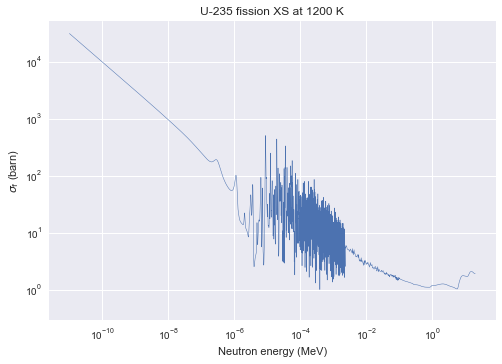

In [16]:
fig, ax = plt.subplots()
ax.loglog(U235_12_ene, U235_12_xs_f)
ax.set(xlabel=ene, ylabel=xs_f, title='U-235 fission XS at 1200 K')
ax.set_ylim(ymin=0.3)
plt.savefig('U235_1200K_MT18.pdf', bbox_inches='tight')

I can also do a plot to project a few points of interest onto the axis.
In this plot, I marked the points at 2 MeV (mean neutron energy at fission),
0.065 eV (neutron energy in thermal equilibrium with a medium at aproximately
600 K), and 0.025 eV (neutron energy in thermal equilibrium with ambient
temperature).

The increase in cross section from 0.065 to 0.025 eV is very high, due to the
logarithmic nature of the plot.
This is why I mentioned before that logarithmic scales are deceptive unless
you put some thought into getting used to it.

The increase in cross sections that happen by bringing a reactor from operating
temperature to ambient/shut down temperature will naturally have consequences
for cold criticality and points out to the importance of neutron absorbers in
excess to what would be needed just for operation at nominal temperature.

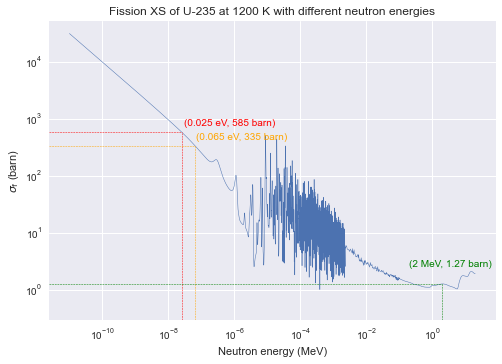

In [17]:
fig, ax = plt.subplots()
ax.loglog(U235_12_ene, U235_12_xs_f)
ax.set(xlabel=ene,ylabel=xs_f,
       title='Fission XS of U-235 at 1200 K with different neutron energies')
ax.set_ylim(ymin=0.3)

ene, fis = 0.025E-6, 585
ax.axvline(ene, ymax=0.625,
           color='red',
           linewidth='0.5',
           linestyle='--')
ax.axhline(fis, xmax=0.297,
           color='red',
           linewidth='0.5',
           linestyle='--')
ax.annotate('(0.025 eV, 585 barn)', (ene, fis),
            xytext=(2.9E-8, 750),
            color='red')

ene, fis = 0.065E-6, 335
ax.axvline(ene, ymax=0.582,
           color='orange',
           linewidth='0.5',
           linestyle='--')
ax.axhline(fis, xmax=0.327,
           color='orange',
           linewidth='0.5',
           linestyle='--')
ax.annotate('(0.065 eV, 335 barn)', (ene, fis),
            xytext=(7.1E-8, 440),
            color='orange')

ene, fis = 2, 1.27
ax.axvline(ene, ymax=0.12,
           color='green',
           linewidth='0.5',
           linestyle='--')
ax.axhline(fis, xmax=0.88,
           color='green',
           linewidth='0.5',
           linestyle='--')
ax.annotate('(2 MeV, 1.27 barn)', (ene, fis),
            xytext=(0.2,2.6),
            color='green')

plt.savefig('U235_1200K_MT18_annotated.pdf', bbox_inches='tight')

Some reaction channels are called threshold reactions.
These are reactions that only start to happen above a certain energy.
An example of such threshold reaction is the inelastic scattering in U235.

To plot such reactions, it is necessary to find the index of the energy where
this reaction starts to happen.
There is an attribute for that.

['IE', 'MT', 'Q', 'TY', '__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'broaden', 'center_of_mass', 'multiplicity', 'sigma', 'table', 'threshold']
This reaction starts at energy index 24200
This index corresponds to an energy of 0.002249999 MeV
Double checking energy from energy grid 0.002249999 MeV
Both values are equal? True


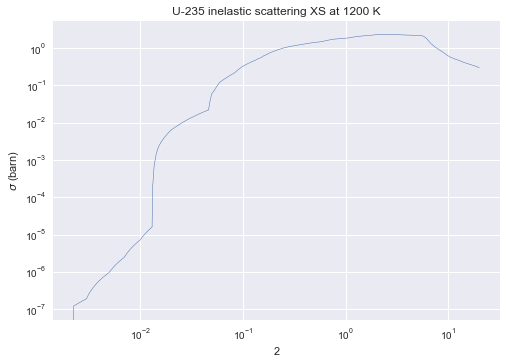

In [18]:
U235_12_inelastic = U235_12.reactions[4]

# print all attributes of the reaction
print(dir(U235_12_inelastic))

# IE or Index Energy, is the attribute that stores the index in the energy
# array where the reaction starts to happen
print('This reaction starts at energy index', U235_12_inelastic.IE)
# There is also a method to show what is the energy value in MeV
print('This index corresponds to an energy of', U235_12_inelastic.threshold(), 'MeV')

# Just to confirm that this energy is correct, let's print the value of energy
# at that index manually
print('Double checking energy from energy grid', U235_12_ene[U235_12_inelastic.IE], 'MeV')
print('Both values are equal?', np.equal(U235_12_inelastic.threshold(), U235_12_ene[U235_12_inelastic.IE]))

# So we slice the array of values to separate just the energies of the
# threshold reaction
# We do this by slicing from the threshold index to the end of the array
U235_12_ene_i = U235_12_ene[U235_12_inelastic.IE:]
U235_12_xs_i = U235_12_inelastic.sigma

fig, ax = plt.subplots()
ax.loglog(U235_12_ene_i, U235_12_xs_i, label='inelastic')
ax.set(xlabel=ene, ylabel=xs, title='U-235 inelastic scattering XS at 1200 K')
plt.savefig('U235_1200K_MT4.pdf', bbox_inches='tight')

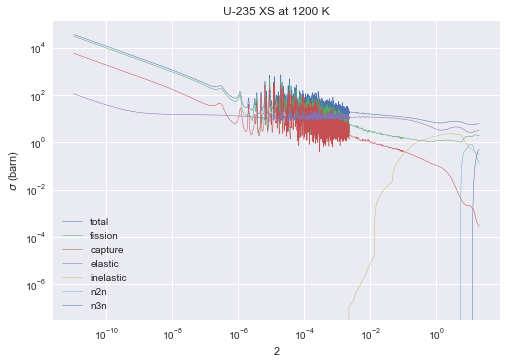

In [19]:
U235_12_xs_e = U235_12.reactions[2].sigma

U235_12_ene_n2n = U235_12_ene[U235_12.reactions[16].IE:]
U235_12_xs_n2n = U235_12.reactions[16].sigma
U235_12_ene_n3n = U235_12_ene[U235_12.reactions[17].IE:]
U235_12_xs_n3n = U235_12.reactions[17].sigma

fig, ax = plt.subplots()
ax.loglog(U235_12_ene, U235_12_xs_t, label='total')
ax.loglog(U235_12_ene, U235_12_xs_f, label='fission')
ax.loglog(U235_12_ene, U235_12_xs_c, label='capture')
ax.loglog(U235_12_ene, U235_12_xs_e, label='elastic')
ax.loglog(U235_12_ene_i, U235_12_xs_i, label='inelastic')
ax.loglog(U235_12_ene_n2n, U235_12_xs_n2n, label='n2n')
ax.loglog(U235_12_ene_n3n, U235_12_xs_n3n, label='n3n')
ax.legend()
ax.set(xlabel=ene, ylabel=xs, title='U-235 XS at 1200 K')
plt.savefig('U235_1200K.pdf', bbox_inches='tight')

It is also interesting to plot the fission cross section at different energies,
showing how doppler effect affects the fission cross section.
The integral under the curves at different energies are the same, but under a
neutron flux the reaction rate is not the same due to self-shielding.
Self-shielding is a very important phenomena that requires a more thorough
explanation later when discussing cross sections and neutron flux together and
how one influences the other.

/Users/rodrigo/opt/anaconda3/envs/nuclear37/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: FixedFormatter should only be used together with FixedLocator


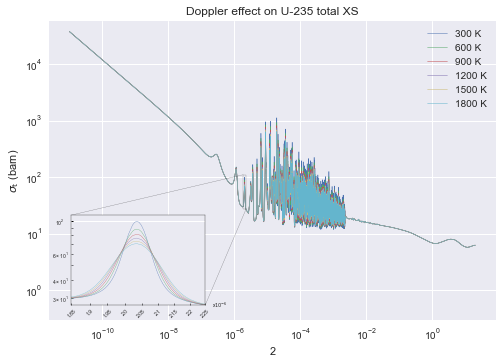

In [20]:
temperatures = [300, 600, 900, 1200, 1500, 1800]
entries = sorted(U235.tables.keys())

fig, ax = plt.subplots()
for entry, temperature in zip(entries, temperatures):
    ax.loglog(U235.tables[entry].energy, U235.tables[entry].sigma_t,
              label=f'{temperature} K')

ax.legend()
ax.set_ylim(ymin=0.3)
ax.set(xlabel=ene,ylabel=xs_t,
       title='Doppler effect on U-235 total XS')

plt.savefig('U235_MT1.pdf')

axins = ax.inset_axes([0.05, 0.05, 0.3, 0.3])
for entry, temperature in zip(entries, temperatures):
    axins.loglog(U235.tables[entry].energy, U235.tables[entry].sigma_t,
                 linewidth=0.3)

axins.set_xlim(1.85E-6, 2.25E-6)
axins.set_ylim(2.7E1, 1.1E2)
for spine in axins.spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.3)
axins.tick_params(axis='both',
                  which='both',
                  direction='in',
                  color='black',
                  length=2,
                  labelsize=5)
axins.tick_params(axis='x',
                  which='both',
                  labelrotation=45)

axins.set_xticklabels([1.85,1.90,1.95,2.00,2.05,2.10,2.15,2.20,2.25],minor=True)
ax.text(1.05, 0, 'x$ 10^{-6} $',
        fontsize=5,
        transform=axins.transAxes,
        horizontalalignment='left',
        verticalalignment='center')

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.savefig('U235_MT1_zoom.pdf')

/Users/rodrigo/opt/anaconda3/envs/nuclear37/lib/python3.7/site-packages/ipykernel_launcher.py:33: UserWarning: FixedFormatter should only be used together with FixedLocator


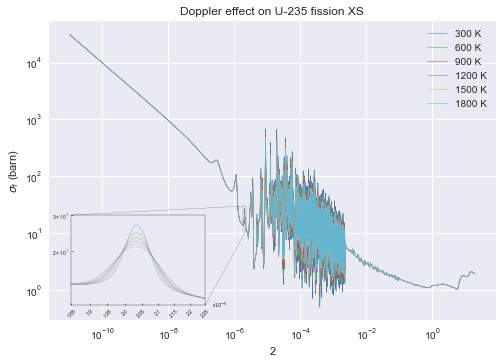

In [21]:
fig, ax = plt.subplots()
for entry, temperature in zip(entries, temperatures):
    ax.loglog(U235.tables[entry].energy, U235.tables[entry].reactions[18].sigma,
              label=f'{temperature} K')

ax.legend()
ax.set_ylim(ymin=0.3)
ax.set(xlabel=ene,ylabel=xs_f,
       title='Doppler effect on U-235 fission XS')

plt.savefig('U235_MT18.pdf')

axins = ax.inset_axes([0.05, 0.05, 0.3, 0.3])
for entry, temperature in zip(entries, temperatures):
    axins.loglog(U235.tables[entry].energy, U235.tables[entry].reactions[18].sigma,
                 linewidth=0.3)

axins.set_xlim(1.85E-6, 2.25E-6)
axins.set_ylim(1.1E1, 3E1)
for spine in axins.spines.values():
    spine.set_color('black')
    spine.set_linewidth(0.3)
axins.tick_params(axis='both',
                  which='both',
                  direction='in',
                  color='black',
                  length=2,
                  labelsize=5)
axins.tick_params(axis='x',
                  which='both',
                  labelrotation=45)

axins.set_xticklabels([1.85,1.90,1.95,2.00,2.05,2.10,2.15,2.20,2.25],minor=True)
ax.text(1.05, 0, 'x$ 10^{-6} $',
        fontsize=5,
        transform=axins.transAxes,
        horizontalalignment='left',
        verticalalignment='center')

ax.indicate_inset_zoom(axins, edgecolor="black")

plt.savefig('U235_MT18_zoom.pdf')

Regardless of the bug, we can make the absorption cross section roughly by
adding fission and capture cross sections.

We can also plot an insightful quantity such as the ratio of absorption to
total cross section.
Since $ \sigma_t = \sigma_a + \sigma_s $ then the complement is the probability
of scattering.

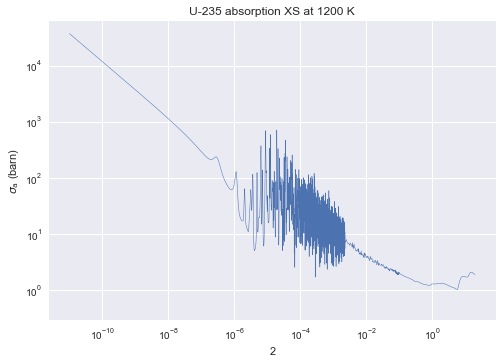

In [22]:
U235_12_xs_a = U235_12_xs_f + U235_12_xs_c

fig, ax = plt.subplots()
ax.loglog(U235_12_ene, U235_12_xs_a)

ax.set(xlabel=ene,ylabel=xs_a,
       title='U-235 absorption XS at 1200 K')
ax.set_ylim(ymin=0.3)

plt.savefig('U235_1200K_abs.pdf', bbox_inches='tight')

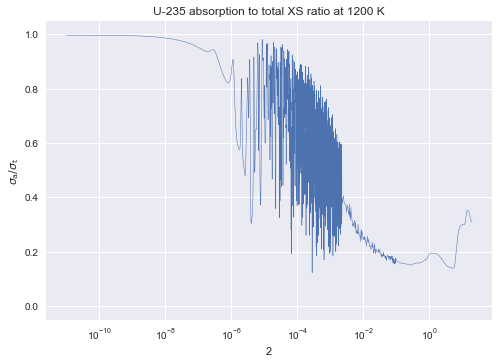

In [23]:
ATR = U235_12_xs_a / U235_12_xs_t

fig, ax = plt.subplots()
ax.semilogx(U235_12_ene, ATR)

ax.set(xlabel=ene,
       ylabel='$ \sigma_{\mathrm{a}} / \sigma_{\mathrm{t}} $',
       title='U-235 absorption to total XS ratio at 1200 K')
ax.set_ylim((-0.05,1.05))

plt.savefig('U235_1200K_ATR.pdf', bbox_inches='tight')

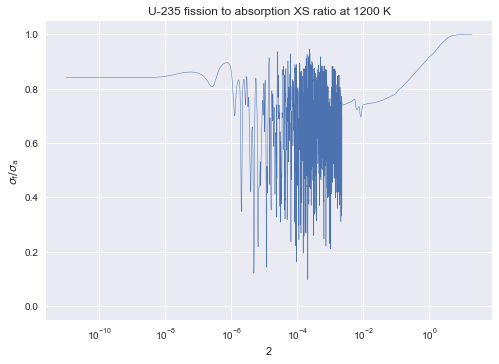

In [24]:
U235_FAR = U235_12_xs_f / U235_12_xs_a

fig, ax = plt.subplots()
ax.semilogx(U235_12_ene, U235_FAR)

ax.set(xlabel=ene,
       ylabel='$ \sigma_{\mathrm{f}} / \sigma_{\mathrm{a}} $ ',
       title='U-235 fission to absorption XS ratio at 1200 K')
ax.set_ylim((-0.05,1.05))

plt.savefig('U235_1200K_FAR.pdf', bbox_inches='tight')

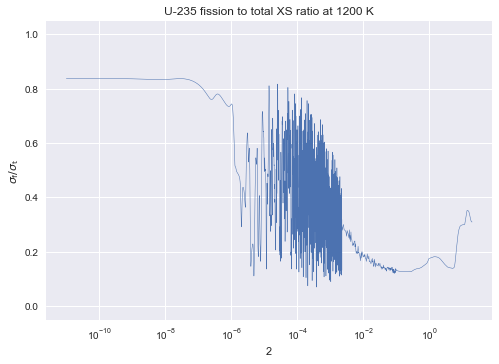

In [25]:
U235_FTR = U235_12_xs_f / U235_12_xs_t

fig, ax = plt.subplots()
ax.semilogx(U235_12_ene, U235_FTR)

ax.set(xlabel=ene,
       ylabel='$ \sigma_{\mathrm{f}} / \sigma_{\mathrm{t}} $ ',
       title='U-235 fission to total XS ratio at 1200 K')
ax.set_ylim((-0.05,1.05))

plt.savefig('U235_1200K_FTR.pdf', bbox_inches='tight')

We can also plot $ \eta $, which is a quantity that shows the amount of
neutrons produced per neutron absorbed.
For this we need to multiply the fission to absorption ration by $ \nu $.

Since $ \nu $ has a different energy grid, to multiply we need to
interpolate it to the cross section energy grid first.

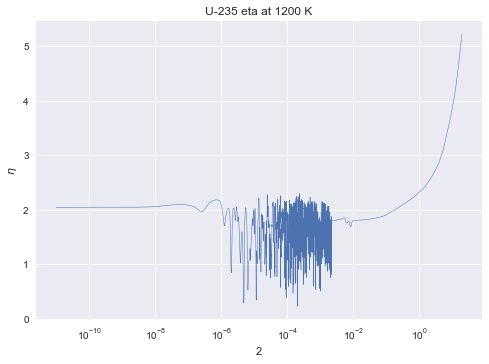

In [26]:
U235_nu = np.interp(U235_12_ene, U235_12.nu_t_energy, U235_12.nu_t_value)
U235_eta = U235_nu * U235_FAR

fig, ax = plt.subplots()
ax.semilogx(U235_12_ene, U235_eta)

ax.set(xlabel=ene,ylabel=eta,
       title='U-235 eta at 1200 K')

plt.savefig('U235_1200K_eta.pdf', bbox_inches='tight')